In [82]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as mplot
from matplotlib.colors import ListedColormap
import os
import subprocess
import sklearn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score,  precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import shap
import lime
from lime import lime_tabular
import random

from sklearn.preprocessing import StandardScaler

from sklearn.tree import export_graphviz
import pydotplus
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import keras
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import networkx as nx

from IPython.display import Image
import pydot



In [83]:
import tensorflow as tf

print(tf.__version__)
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

import dalex as dx
print(dx.__version__)

import torch


2.12.0
False
[]
1.6.0


## Reading Dataset, Preprocessing and making X and Y variables

In [84]:
dataSetIndex = 4
needToMakePictureOfTrees = 0
''' ---------------------------------------------------------- '''
dataSetFilePath = ""
dataSetName = ""
dataSetResultDirectory = "./"

if(dataSetIndex == 0):
    dataSetFilePath = "./heartDisease/0_statLog_dataSet.csv"
    dataSetName = "SateLog_DataSet"
elif (dataSetIndex == 1):
    dataSetFilePath = "./heartDisease/1_heart_statlog_cleveland_hungary_final.csv"
    dataSetName = "ALL_StateLog_CleveLand_Hungary"
elif (dataSetIndex == 2):
    dataSetFilePath = "./heartDisease/2_cleveland.csv"
    dataSetName = "Cleveland"
elif (dataSetIndex == 3):
    dataSetFilePath = "./heartDisease/3_framingham.csv"
    dataSetName = "framingham"
elif (dataSetIndex == 4):
    dataSetFilePath = "./heartDisease/4_CardiacPrediction.xlsx"
    dataSetName = "CardiacPrediction"
elif (dataSetIndex == 5):
    dataSetFilePath = "./heartDisease/5_CardiacPredictionLessDimensions.xlsx"
    dataSetName = "CardiacPrediction"
elif (dataSetIndex == 6):
    dataSetFilePath = "./heartDisease/6_CardiacPredictionFewDimensions.xlsx"
    dataSetName = "CardiacPrediction"
else:
    dataSetFilePath = ""
    dataSetName = ""

if(dataSetIndex==4 or dataSetIndex==5 or dataSetIndex==6):
    #fileData = pd.read_excel(dataSetFilePath, sheet_name='CoroHeartDis')
    fileData = pd.read_excel(dataSetFilePath)
else:
    fileData = pd.read_csv(dataSetFilePath)

print("Shape of fileData: {}".format(fileData.shape))
print("Column Headings: {}".format(fileData.__dataframe__().column_names()))
print("Number of Records: {}".format(fileData.__dataframe__().num_rows()))


missingValues = fileData.isnull().any().sum()
print(f"\nNumber of Missing Values: {missingValues}")

num_rows_before = fileData.shape[0]
# Remove duplicate records based on all columns
fileData.drop_duplicates(inplace=True)
# Check the number of rows after removing duplicates
num_rows_after = fileData.shape[0]
# Print the number of duplicate records removed
num_duplicates_removed = num_rows_before - num_rows_after
print(f"Number of duplicate records removed: {num_duplicates_removed}")
 
 # Preprocess Steps from the ChatGPT
# 1. Handling Missing Values:
fileData = fileData.dropna()
print("Shape of fileData: {}".format(fileData.shape))              
#fileData.replace({'?': np.nan}).dropna().astype(float)
#fileData = fileData.fillna(0) 

fileData = fileData.fillna(0) 

print("Shape of fileData End: {}".format(fileData.shape))



finalResultTable = [ ['Index', 'Method', 'Accuracy %','Recall %','Precision %','F1 Score'], ] 
'''
dataSetResultDirectory += ("DatasetResults_" + dataSetName)
dataSetResultDirectory += "/"
if not os.path.isdir(dataSetResultDirectory):
    os.makedirs(dataSetResultDirectory)

dataSetName += " {}".format(fileData.shape)
'''

X = fileData.drop(fileData.__dataframe__().column_names()[-1], axis=1)  # Features
Y = fileData[fileData.__dataframe__().column_names()[-1]]  # Labels

columns = fileData.__dataframe__().column_names() 
totalRecords = (fileData.__dataframe__().num_rows())

print("\n")
print("columns of x:: {} \n\n and features of X: {}".format(len(X.columns), X.columns))




Shape of fileData: (37079, 51)
Column Headings: Index(['SEQN', 'Gender', 'Age', 'Annual-Family-Income',
       'Ratio-Family-Income-Poverty', 'X60-sec-pulse', 'Systolic', 'Diastolic',
       'Weight', 'Height', 'Body-Mass-Index', 'White-Blood-Cells',
       'Lymphocyte', 'Monocyte', 'Eosinophils', 'Basophils', 'Red-Blood-Cells',
       'Hemoglobin', 'Mean-Cell-Vol', 'Mean-Cell-Hgb-Conc.',
       'Mean-cell-Hemoglobin', 'Platelet-count', 'Mean-Platelet-Vol',
       'Segmented-Neutrophils', 'Hematocrit', 'Red-Cell-Distribution-Width',
       'Albumin', 'ALP', 'AST', 'ALT', 'Cholesterol', 'Creatinine', 'Glucose',
       'GGT', 'Iron', 'LDH', 'Phosphorus', 'Bilirubin', 'Protein', 'Uric.Acid',
       'Triglycerides', 'Total-Cholesterol', 'HDL', 'Glycohemoglobin',
       'Vigorous-work', 'Moderate-work', 'Health-Insurance', 'Diabetes',
       'Blood-Rel-Diabetes', 'Blood-Rel-Stroke', 'CoronaryHeartDisease'],
      dtype='object')
Number of Records: 37079

Number of Missing Values: 0
Number o

## Making Training 70% and Testing 30%

In [85]:

#print("columns of x:: {} \n\n and features of X: {}".format(len(X.columns), X.columns))
 
print("***************************************") 

print("Shape of fileData: {} , target Len:{}".format(fileData.shape, len(Y)))
print("X: {} , Y:{}".format(X.shape, Y.shape))
#print("\n\nX: head:: \n{}".format(X.head()))
#print("\n\nY: head::\n {}".format(Y.head()))

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)
 

print("Target Column Name:: {} \n".format(fileData.__dataframe__().column_names()[-1]))

# Undersample the majority class
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)
'''

# Oversample the minority class using SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


'''

# Print the class distribution after undersampling
print("Class distribution after undersampling:")
print(pd.Series(y_train).value_counts())




print("\n X Train: Shape:: {}".format(X_train.shape))
print(" X Test: Shape:: {}".format(X_test.shape))

'''
print("\n X Train: Shape::\n {}".format(X_train.shape))
print("\n X Train: head::\n {}".format(X_train.columns))
print("\n X Test: head:: \n{}".format(X_test.columns))
print("\n Y Train: shape::\n {}".format(y_train.shape)) 
print("\n Y Test: shape::\n {}".format(y_test.shape)) 
'''
#print("\n X Train: Info::\n {}".format(X_train.info())) 


instance = np.array(X_test)  # Example: explaining the first instance in the dataset
 
dataSetResultDirectory += ("DatasetResults_" + dataSetName)
dataSetResultDirectory += "/"
if not os.path.isdir(dataSetResultDirectory):
    os.makedirs(dataSetResultDirectory)

dataSetName += " {}".format(fileData.shape)


***************************************
Shape of fileData: (37079, 51) , target Len:37079
X: (37079, 50) , Y:(37079,)
Target Column Name:: CoronaryHeartDisease 

Class distribution after undersampling:
0    1056
1    1056
Name: CoronaryHeartDisease, dtype: int64

 X Train: Shape:: (2112, 50)
 X Test: Shape:: (11124, 50)


In [86]:
# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(50,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [87]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)



Epoch 1/20
66/66 [==============================] - 1s 1ms/step - loss: 0.5800 - accuracy: 0.7055
Epoch 2/20
66/66 [==============================] - 0s 1ms/step - loss: 0.4758 - accuracy: 0.7817
Epoch 3/20
66/66 [==============================] - 0s 1ms/step - loss: 0.4360 - accuracy: 0.7931
Epoch 4/20
66/66 [==============================] - 0s 1ms/step - loss: 0.4094 - accuracy: 0.8101
Epoch 5/20
66/66 [==============================] - 0s 1ms/step - loss: 0.3904 - accuracy: 0.8215
Epoch 6/20
66/66 [==============================] - 0s 2ms/step - loss: 0.3774 - accuracy: 0.8234
Epoch 7/20
66/66 [==============================] - 0s 1ms/step - loss: 0.3606 - accuracy: 0.8281
Epoch 8/20
66/66 [==============================] - 0s 1ms/step - loss: 0.3465 - accuracy: 0.8419
Epoch 9/20
66/66 [==============================] - 0s 1ms/step - loss: 0.3304 - accuracy: 0.8537
Epoch 10/20
66/66 [==============================] - 0s 1ms/step - loss: 0.3165 - accuracy: 0.8632
Epoch 11/20
66/66 [

In [88]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test loss: {loss * 100}')
print(f'Test accuracy: {accuracy * 100}')

348/348 [==============================] - 0s 869us/step - loss: 0.6408 - accuracy: 0.7469
Test loss: 64.08486366271973
Test accuracy: 74.68536496162415


In [89]:
# Get the model predictions
y_pred = model.predict(X_test)

# Convert probabilities into class labels
y_pred = np.where(y_pred > 0.5, 1, 0)
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

348/348 [==============================] - 0s 661us/step
[[7950 2722]
 [  94  358]]


In [93]:
def makeConfusionMatrixPic(fileID, method, dataSet, cm , X_test, y_test, predicted_Y):
    
    display = ConfusionMatrixDisplay.from_predictions(y_test,predicted_Y, display_labels=['Healthy', "Heart Disease"], cmap=mplot.cm.Blues) #, normalize="true"
    
         
    display.ax_.set_title("Confusion Matrix ({} Model)".format(method) ,fontsize=16, fontweight='bold')
    display.ax_.set_xlabel('\nPredicted Values')
    display.ax_.set_ylabel('Actual Values ')

    accuracyValue = (accuracy_score(y_test, predicted_Y)*100.0) 
    recallValue = (recall_score(y_test, predicted_Y, average='weighted') * 100.0)
    precisionValue = (precision_score(y_test, predicted_Y) * 100.0) 
    f1Score = (f1_score(y_test, predicted_Y, average='weighted') * 100.0)

 
    singleRowInTable = [] 
    singleRowInTable.append(fileID)
    singleRowInTable.append(method)
    singleRowInTable.append("{:.2f}".format(accuracyValue) )
    singleRowInTable.append("{:.2f}".format(recallValue) )
    singleRowInTable.append("{:.2f}".format(precisionValue) )
    singleRowInTable.append("{:.2f}".format(f1Score) )

    finalResultTable.append((singleRowInTable) )


    accuracyString ="Accuracy : {:.2f} %".format( accuracyValue) 
    recallString =  'Recall : {:.2f} %'.format(recallValue)
    precisionString = 'Precision : {:.2f} %'.format(precisionValue) 
    precisionString = 'Precision : {:.2f} %'.format(precisionValue) 
    f1String = 'F1 Score : {:.2f} %'.format(f1Score) 
    dataSetString = "Dataset: {}".format(dataSet)
    
    numberOfTrainingRecords = "No of Training Records: {}  {:.2f} %".format(len(X_train), ((len(X_train)/totalRecords) * 100.0))
    numberOfTestingRecords = "No of Testing Records: {}  {:.2f} %".format(len(X_test), ((len(X_test)/totalRecords) * 100.0))

    display.figure_.text(0.010, -0.05,  accuracyString, horizontalalignment='left', wrap=False , fontsize=12 )  
    display.figure_.text(0.010, -0.09,  recallString, horizontalalignment='left', wrap=False , fontsize=12 )      
    display.figure_.text(0.010, -0.13,  precisionString, horizontalalignment='left', wrap=False , fontsize=12 ) 
    display.figure_.text(0.010, -0.17,  f1String, horizontalalignment='left', wrap=False , fontsize=12 ) 
    display.figure_.text(0.010, -0.21,  dataSetString, horizontalalignment='left', wrap=False , fontsize=12 ) 
    display.figure_.text(0.010, -0.25,  numberOfTrainingRecords, horizontalalignment='left', wrap=False , fontsize=12 ) 
    display.figure_.text(0.010, -0.29,  numberOfTestingRecords, horizontalalignment='left', wrap=False , fontsize=12 ) 
    
    '''
    if(classifierObj.n_features_in_ > 10):
        featureListString = 'Total Features: {}'.format(classifierObj.n_features_in_) 
    else:
        featureListString = 'Features: {}'.format(classifierObj.feature_names_in_) 
    display.figure_.text(0.010, -0.28,  featureListString, horizontalalignment='left', wrap=False , fontsize=12 ) 
    '''
    
    picturePath = "{}{}.Confusion_Matrix_{}_{}.png".format(dataSetResultDirectory, fileID, method, dataSetName)
    mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
    #print("{} Confusion Matrix saved:: path: {}".format(method, picturePath))
    #os.startfile(picturePath)
    mplot.show()
    mplot.close()

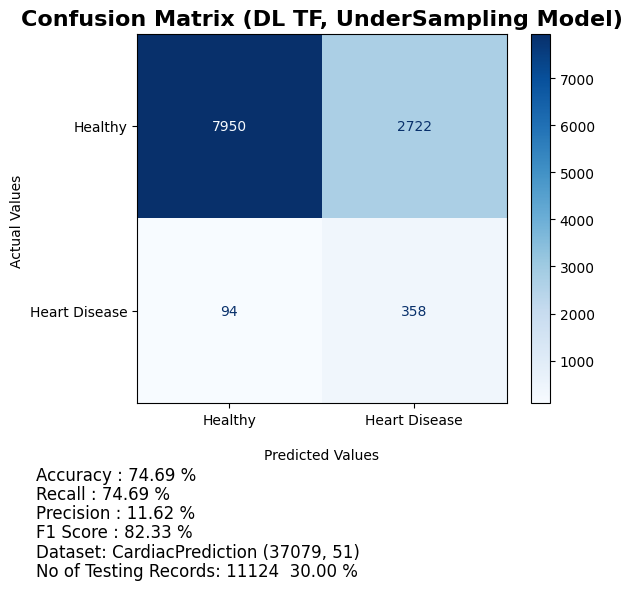

In [94]:
makeConfusionMatrixPic(52, "DL TF, UnderSampling", dataSetName, cm , X_test, y_test, y_pred)

In [ ]:

# Save the model summary as a text file
with open('model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

# Read the model summary from the text file
with open('model_summary.txt', 'r') as f:
    summary_text = f.read()

# Create a figure and axis
fig, ax = mplot.subplots(figsize=(8, 6))

# Set the text as the title of the plot
ax.set_title('Model Summary')
ax.text(0.5, 0.5, summary_text, va='center', ha='center', fontsize=10)

# Remove the axis
ax.axis('off')

picturePath = "{}{}.Model_Summary_{}_{}.png".format(dataSetResultDirectory, 50, "DL TF", dataSetName)
plot_model(model, to_file=picturePath, show_shapes=True, expand_nested=True, dpi=96, show_layer_names=True, show_dtype=False, rankdir='TB', show_layer_activations=True, show_trainable=True)
picturePath = "{}{}.Model_Summary_{}_{}.png".format(dataSetResultDirectory, 51, "DL TF", dataSetName)
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')

# Show the plot
mplot.show()

Second Model

In [ ]:
n, p = X.shape

tf.random.set_seed(11)

normalizer  = tf.keras.layers.experimental.preprocessing.Normalization(input_shape=[p,])
normalizer.adapt(X.to_numpy())

model = tf.keras.Sequential([
    normalizer,
    tf.keras.Input(shape=(p,)),
    tf.keras.layers.Dense(p*2, activation='relu'),
    tf.keras.layers.Dense(p*3, activation='relu'),
    tf.keras.layers.Dense(p*2, activation='relu'),
    tf.keras.layers.Dense(p, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.mae
)



In [ ]:
model.fit(X, Y, batch_size=int(n/10), epochs=2000, verbose=False)


In [ ]:
explainer = dx.Explainer(model, X, Y, label='CoronaryHeartDisease')


In [ ]:
explainer.model_performance()
explainer.model_parts().plot()


In [ ]:

'''
Shape of fileData: (37079, 51)
Column Headings: Index(['SEQN', 'Gender', 'Age', 'Annual-Family-Income',
       'Ratio-Family-Income-Poverty', 'X60-sec-pulse', 'Systolic', 'Diastolic',
       'Weight', 'Height', 'Body-Mass-Index', 'White-Blood-Cells',
       'Lymphocyte', 'Monocyte', 'Eosinophils', 'Basophils', 'Red-Blood-Cells',
       'Hemoglobin', 'Mean-Cell-Vol', 'Mean-Cell-Hgb-Conc.',
       'Mean-cell-Hemoglobin', 'Platelet-count', 'Mean-Platelet-Vol',
       'Segmented-Neutrophils', 'Hematocrit', 'Red-Cell-Distribution-Width',
       'Albumin', 'ALP', 'AST', 'ALT', 'Cholesterol', 'Creatinine', 'Glucose',
       'GGT', 'Iron', 'LDH', 'Phosphorus', 'Bilirubin', 'Protein', 'Uric.Acid',
       'Triglycerides', 'Total-Cholesterol', 'HDL', 'Glycohemoglobin',
       'Vigorous-work', 'Moderate-work', 'Health-Insurance', 'Diabetes',
       'Blood-Rel-Diabetes', 'Blood-Rel-Stroke', 'CoronaryHeartDisease'],
'''

#explainer.predict_parts(X_train[50], type='shap').plot()
lime_explanation = explainer.predict_surrogate(X_train.loc[1], mode='regression')



## Methods Definitions

In [ ]:
def makeCorrelationPic(correlationMatrix, numberOfTopFeatures, targetColumnName):     
    correlation_values = correlationMatrix.abs()
    sorted_correlation = correlation_values.unstack().sort_values(ascending=False)
    sorted_correlation = sorted_correlation[sorted_correlation != 1.0]

    num_features = numberOfTopFeatures  # Number of top features to display
    top_features = sorted_correlation.head(num_features)
    print("Top", num_features, "features based on correlation:")
    print(top_features)
 
    top_features = correlationMatrix.abs().nlargest(numberOfTopFeatures, targetColumnName)[targetColumnName].index
    top_correlation_matrix = correlationMatrix.loc[top_features, top_features]

    mplot.figure(figsize=(10, 8))
    sns.heatmap(top_correlation_matrix, annot=True, cmap='coolwarm')
    # Set the title of the plot
    mplot.title('Correlation Heatmap ({})'.format(dataSetName)  ,fontsize=16, fontweight='bold')
    
    picturePath = "{}0.1_Correlation_Matrix_DateSetName_{}.png".format(dataSetResultDirectory, dataSetName)
    mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
    mplot.show()
    mplot.close()
def plot_classification_report(title, dataSetName, y_tru, y_prd, figsize=(6, 6), ax=None):
    #mplot.figure(figsize=figsize)
    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = ['Healthy', 'Heart Disease']
    rep = np.array( precision_recall_fscore_support(y_tru, y_prd) ).T
    rep[0][0] *= 100.0
    rep[0][1] *= 100.0
    rep[0][2] *= 100.0
    rep[1][0] *= 100.0
    rep[1][1] *= 100.0
    rep[1][2] *= 100.0
    
    ax = sns.heatmap(rep, annot=True, cmap='Blues', cbar=False, xticklabels=xticks, yticklabels=yticks)
    ax.set_title("Classification Report {} Model\n\n".format(title) ,fontsize=16, fontweight='bold')
    ax.set_xlabel('\nDataset:{}'.format(dataSetName))
    ax.xaxis.set_ticklabels(xticks)
    ax.set_ylabel('Classes')
    ax.yaxis.set_ticklabels(yticks)
    
    picturePath = "{}ClassificationReport_{}_{}.png".format(dataSetResultDirectory, title, dataSetName) 
    mplot.savefig(picturePath, dpi=300, bbox_inches='tight')
    #os.startfile(picturePath)
    mplot.close()

def makeLIMEreport(method, classifierObj):
    class_names =  ['Healthy', 'Heart Disease']
    listOfFeatures =  classifierObj.feature_names_in_
    print("\n\n\n Obj Features: {}, len: {} \n\n".format(listOfFeatures, len(listOfFeatures)))
    #explainer = lime_tabular.LimeTabularExplainer(np.array(X_train) , mode='regression', feature_names=listOfFeatures, verbose=True, class_names=class_names )
    explainer = lime_tabular.LimeTabularExplainer(np.array(X_train) , mode='classification', feature_names=listOfFeatures, verbose=True, class_names=class_names )

    num_instances = int(len(X_test)/4)
    print("num_instances: {}".format(num_instances))
    # Generate explanations for each testing instance
    explanations = []
    for i in range(num_instances):
        instan = instance[i]
        explanation = explainer.explain_instance(instan, classifierObj.predict_proba, num_features=len(instan))
        explanations.append(explanation)

    #Extract the feature importance values from the explanations
    feature_importances = np.mean([exp.as_map()[1] for exp in explanations], axis=0)
    averageF = []
    for singleFeature in feature_importances:
        averageF.append(singleFeature[0])
     
    print("\n\nfeature_list:{}".format(listOfFeatures))
    print("averageF:{} \n\n".format(averageF))


    fig, ax = mplot.subplots()
    ax.barh(listOfFeatures, averageF )
    ax.set_ylabel('Feature List')
    ax.set_xlabel('Average Importance')
    ax.set_title("XAI LIME ({} Model)".format(method) ,fontsize=16, fontweight='bold')
     
    dataSetString = "Dataset:  {}".format(dataSetName)
    testingDatasetString ="length of Testing Set: {}".format(len(X_test))
    explainerModelString = "LIME Explainer Model: {}".format(explainer.mode)
    ax.figure.text(0.020, -0.05,  dataSetString, horizontalalignment='left', wrap=False )  
    ax.figure.text(0.020, -0.09,  testingDatasetString, horizontalalignment='left', wrap=False )   
    ax.figure.text(0.020, -0.13,  explainerModelString, horizontalalignment='left', wrap=False )   
 

    picturePath = "{}XAI_LIME_{}_{}.png".format(dataSetResultDirectory, method, dataSetName)
    mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
    #mplot.savefig(picturePath,  dpi=300) 
    #os.startfile(picturePath)
    mplot.show()
    mplot.close()
def makeSHAPreport(method, model):
    shap_explainer = shap.Explainer(model, X_train) 
    shap_values = shap_explainer.shap_values(X_test)  
    shap.summary_plot(shap_values, X_test, show=False)
    ax = mplot.gca() 
    ax.set_title("XAI SHAP Explainer ({} Model)".format(method) ,fontsize=16, fontweight='bold')     

    dataSetString = "Dataset:  {}".format(dataSetName)
    testingDatasetString ="length of Testing Set: {}".format(len(X_test))
    shapTypeString ="SHAP Type: {}".format(repr(shap_explainer)) 
    ax.figure.text(0.020, -0.05,  dataSetString, horizontalalignment='left', wrap=False )  
    ax.figure.text(0.020, -0.09,  testingDatasetString, horizontalalignment='left', wrap=False )   
    ax.figure.text(0.020, -0.13,  shapTypeString, horizontalalignment='left', wrap=False )   

    picturePath = "{}XAI_SHAP_Explainer_{}_{}.png".format(dataSetResultDirectory, method, dataSetName)
    mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
    #mplot.savefig(picturePath,  dpi=300) 
    mplot.show()
    #os.startfile(picturePath)
    mplot.close()
def makeSHAP_KERNELreport(method, model):
    shap_explainer = shap.KernelExplainer(model.predict_proba, X_train) 
    testingShape = X_test[0:10]
    shap_values = shap_explainer.shap_values(testingShape)  
    shap.summary_plot(shap_values, X_test, show=False)
    ax = mplot.gca() 
    ax.set_title("XAI SHAP KernelExplainer ({} Model)".format(method) ,fontsize=16, fontweight='bold')     

    dataSetString = "Dataset:  {}".format(dataSetName)
    testingDatasetString ="length of Testing Set: {}".format(len(testingShape))
    shapTypeString ="SHAP Type: {}".format(repr(shap_explainer)) 
    ax.figure.text(0.020, -0.05,  dataSetString, horizontalalignment='left', wrap=False )  
    ax.figure.text(0.020, -0.09,  testingDatasetString, horizontalalignment='left', wrap=False )   
    ax.figure.text(0.020, -0.13,  shapTypeString, horizontalalignment='left', wrap=False )   

    picturePath = "{}XAI_SHAP_KernelExplainer_{}_{}.png".format(dataSetResultDirectory, method, dataSetName)
    mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
    #mplot.savefig(picturePath,  dpi=300) 
    mplot.show()
    #os.startfile(picturePath)
    mplot.close()
   

In [ ]:
# Deep Learning Model
kerasSequentialModel = Sequential();

kerasSequentialModel.add(Dense(13,  input_dim=13, activation='relu'))
kerasSequentialModel.add(Dense(8, activation='relu'))
kerasSequentialModel.add(Dense(1, activation='sigmoid'))

# loss='mean_sequared_error'
#kerasSequentialModel.compile(optimizer="adam", loss='binary_crossentropy')
kerasSequentialModel.compile(optimizer="adam", loss='mean_squared_error')
 


In [ ]:
#kerasSequentialModel.fit(X_train, y_train, epochs=10, batch_size=10 )
# Train model
#kerasSequentialModel.fit(X_train, y_train, batch_size=30, epochs=10, verbose=False, validation_data=(X_test, y_test))
kerasSequentialModel.fit(X_train, y_train, epochs=50, batch_size=10)


In [ ]:
#np.asarray(X_train).astype('float32')
#score = kerasSequentialModel.evaluate(np.asarray(X_test).astype('float32'), np.asarray(y_test).astype('float32'), verbose=0)
score = kerasSequentialModel.evaluate(np.asarray(X_test).astype('float32'), np.asarray(y_test).astype('float32') )
print('Test Score:', score)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Summary of neural network
kerasSequentialModel.summary()

In [ ]:

predictionsKerasSequential = kerasSequentialModel.predict(np.asarray(X_test).astype('float32'))

print('Test Score:', predictionsKerasSequential)

methodName = "Keras Sequential Model" 
#plot_classification_report(methodName, dataSetName, y_test, predictionsKerasSequential)  
makeConfusionMatrixPic(methodName, dataSetName, kerasSequentialModel , np.asarray(X_test).astype('float32'), np.asarray(y_test).astype('float32'), predictionsKerasSequential) 
  
confusionMatric = confusion_matrix(y_test, predictionsKerasSequential)
print("{} ConfusionMatrix: {}".format(methodName, confusionMatric))
print("Accuracy {}:  {}".format(methodName, accuracy_score(y_test, predictionsKerasSequential)))

In [ ]:

 
#fpr, tpr, thresholds = roc_curve(y_test, classifierLR.predict_proba(X_test)[:,1])
mplot.figure()
#mplot.plot(fpr, tpr, label="(area = {:.2f})".format(logit_roc_auc))

fprLR, tprLR, threshLR = roc_curve(y_test, classifierLR.predict_proba(X_test)[:,1])
#fprSVM, tprSVM, threshSVM = roc_curve(y_test, classifierSVM.predict_proba(X_test)[:,1])
fprKNN, tprKNN, threshKNN = roc_curve(y_test, classifierKNN.predict_proba(X_test)[:,1])
fprNB, tprNB, threshNB = roc_curve(y_test, classifierNB.predict_proba(X_test)[:,1])
 
    
# plotting    
mplot.plot(fprLR, tprLR, linestyle='--',color='green', label='Class 1 vs Rest')
#mplot.plot(fprSVM, tprSVM, linestyle='--',color='orange', label='Class 0 vs Rest')
mplot.plot(fprKNN, tprKNN, linestyle='--',color='blue', label='Class 2 vs Rest')
mplot.plot(fprNB, tprNB, linestyle='--',color='red', label='Class 2 vs Rest')
mplot.title('Multiclass ROC curve')
mplot.xlabel('False Positive Rate')
mplot.ylabel('True Positive rate')
mplot.legend(loc='best')
mplot.savefig('Multiclass ROC',dpi=300);    
mplot.show